# Plot AE waveforms

Plotting the AE waveforms with the sensor locations.
The aim of plot is to show a set of waveforms corresponding to the figure for the strain and AE waveforms.

2024.06.09 Kurama Okubo

- 2024.09.02 update for gouge event 61
- 2024.12.23 update for new catalog
- 2025.1.22 Apply band-pass, instead of high-pass, with the one-way sos filter to avoid the acausal artifacts.
- 2025.1.23 Plot the four sensor names.
- 2025.2.24 Change the patch name from G3 to P3.

In [18]:
import os
import obspy
from obspy import read, Stream, Trace
from scipy import signal
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import matplotlib as mpl
%matplotlib inline
import glob
from glob import glob
import numpy as np
import pandas as pd
import datetime
from datetime import timedelta
from tqdm import tqdm
import warnings
import time
import pickle 
import seaborn as sns
from scipy.optimize import minimize

from obspy.signal.cross_correlation import correlate, xcorr_max

from obspy.core.utcdatetime import UTCDateTime    

%load_ext autoreload
%autoreload 2

plt.rcParams["font.family"] = 'Arial'
# plt.rcParams["font.sans-serif"] = "DejaVu Sans, Arial, Helvetica, Lucida Grande, Verdana, Geneva, Lucid, Avant Garde, sans-serif"
plt.rcParams["font.size"] = 10
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 4.75
plt.rcParams["xtick.major.width"] = 0.5 #0.75
plt.rcParams["xtick.minor.size"] = 3
plt.rcParams["xtick.minor.width"] = 0.4
plt.rcParams["xtick.minor.visible"] = True

plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.size"] = 4.75
plt.rcParams["ytick.major.width"] = 0.5 #0.75
plt.rcParams["ytick.minor.size"] = 3
plt.rcParams["ytick.minor.width"] = 0.4
plt.rcParams["ytick.minor.visible"] = True

plt.rcParams["savefig.transparent"] = True

plt.rcParams['axes.linewidth'] = 0.5
os.environ['TZ'] = 'GMT' # change time zone to avoid confusion in unix_tvec conversion
UTCDateTime.DEFAULT_PRECISION = 8 # increase the time precision


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
# channel table
channel_finame = '../../../Others/AEchanneltable/AEsensorlocation_onFB03_table.csv'

# output datadir
data_inputdir = "../../../SourceInvFit/data/07_DATA_MTinversion"

# select balldrop calibration model
balldrop_model=4 # 2 for the model only with SiTj, 4 for the SiTjbeta

if balldrop_model==4:
    aperturecorrection=True
elif balldrop_model==2:
    aperturecorrection=False
else:
    aperturecorrection=False
    
# Path for event location table
datadir = f"../../../SourceInvFit/data/06_2_assemble_gf_model{balldrop_model}"

# read foreshock or aftershock table

# path for the source parameters
# data_gougeeventsourceparm = "../../EnergyBudget/data/gougeevent_sourceparameters.csv"

In [20]:
figdir = "../figure/"
if not os.path.exists(figdir):
    os.makedirs(figdir)

In [21]:
# Read Channel Index
df_array = pd.read_csv(channel_finame)

channel_loc={}

for i in range(len(df_array)):
    stnm = df_array.iloc[i].Instrument_Label
    xtemp = df_array.iloc[i].North.astype('float')
    ytemp = df_array.iloc[i].East.astype('float')
    ztemp = df_array.iloc[i].Down.astype('float')
    channel_loc[stnm] = [xtemp, ytemp, ztemp]
    
AEsensors = list(channel_loc.keys())
# channel_loc

# Read the waveforms
We read the waveforms compiled in `06_assemble_greensfunction_MTinv_removeresp`.
We use the `stage 1`, where the instrumental response and gain correction by the ball drop were applied.


In [22]:
gougeevent_id = 72 #30
datacase = f"fb03-087__{gougeevent_id:04d}"
    
print(f"start processing event {datacase}.")

# load event trace
st_event = read(datadir + "/{}_AEwaveform_forFig2.pickle".format(datacase)) # this contains observation and green's function within a thresholded distance
st_event_obs = st_event.select( location="stage1" )



start processing event fb03-087__0072.


In [23]:
st_event_obs

19 Trace(s) in Stream:
FB.OL03.stage1.OZ | 2023-05-29T00:02:10.73444900Z - 2023-05-29T00:02:10.73475900Z | 10000000.0 Hz, 3101 samples
FB.OL04.stage1.OZ | 2023-05-29T00:02:10.73444900Z - 2023-05-29T00:02:10.73475900Z | 10000000.0 Hz, 3101 samples
FB.OL05.stage1.OZ | 2023-05-29T00:02:10.73444900Z - 2023-05-29T00:02:10.73475900Z | 10000000.0 Hz, 3101 samples
FB.OL06.stage1.OZ | 2023-05-29T00:02:10.73444900Z - 2023-05-29T00:02:10.73475900Z | 10000000.0 Hz, 3101 samples
FB.OL07.stage1.OZ | 2023-05-29T00:02:10.73444900Z - 2023-05-29T00:02:10.73475900Z | 10000000.0 Hz, 3101 samples
FB.OL08.stage1.OZ | 2023-05-29T00:02:10.73444900Z - 2023-05-29T00:02:10.73475900Z | 10000000.0 Hz, 3101 samples
FB.OL09.stage1.OZ | 2023-05-29T00:02:10.73444900Z - 2023-05-29T00:02:10.73475900Z | 10000000.0 Hz, 3101 samples
FB.OL10.stage1.OZ | 2023-05-29T00:02:10.73444900Z - 2023-05-29T00:02:10.73475900Z | 10000000.0 Hz, 3101 samples
FB.OL11.stage1.OZ | 2023-05-29T00:02:10.73444900Z - 2023-05-29T00:02:10.73475900Z

In [24]:
with open(data_inputdir+"/GridSearch_param_{}_balldropmodel{}.pickle".format(datacase, balldrop_model),"rb") as fo:
    param = pickle.load(fo)

In [25]:
# datacases_selected = ['fb03-087__0030',
#  'fb03-087__0090',
#  'fb03-087__0043',
#  'fb03-087__0091',
#  'fb03-087__0082',
#  'fb03-087__0071',
#  'fb03-087__0052',
#  'fb03-087__0081',
#  'fb03-087__0003',
#  'fb03-087__0099',
#  'fb03-087__0016',
#  'fb03-087__0051',
#  'fb03-087__0021',
#  'fb03-087__0061',
#  'fb03-087__0104']

# cmap = sns.color_palette("viridis_r", as_cmap=True)


In [26]:
# # Color for the selected events
# skipcolor = 8
# c_norm = mpl.colors.Normalize(vmin=0, vmax=len(datacases_selected)+skipcolor)
# lc_dict = dict()
# for i, dd in enumerate(datacases_selected):
#     lc_dict[dd] = cmap(c_norm(i+skipcolor))

# lc_dict

In [27]:
# load color dictionary consistent to the plot of the repeated waveforms
gougepatch_id = "G3"
repeated_sensor_lcdict = "OL08" # the color dict is same for all the sensor although separately saved.
with open(f'../../../ComputeScaling/data/01_plot_gougeevents/lc_dict_{gougepatch_id}_{repeated_sensor_lcdict}.pkl', 'rb') as fi:
    lc_dict = pickle.load(fi)

In [28]:
datacase

'fb03-087__0072'

In [29]:
# Compute p wave arrival
cp = param["cp"]
print(cp)
faultwidth = 0.1 #[m]
zs = 0.07 # vertical distance of sensor 
gouge_loc = 1.7465 # relocated hypocenter #1.75
p_arriv_x = np.linspace(-0.6, 0.6, 101) + gouge_loc # relative location from source
p_arriv_t = []
for x in p_arriv_x:
    llen = np.sqrt((x-gouge_loc)**2 + (faultwidth/2)**2)
    rlen = np.sqrt(llen**2 + (zs)**2) # source distance
    p_arriv_t.append(rlen/cp * 1e3)


6200


In [30]:
# Parameters for filtering
# We use the same filter as the previously analyzed gouge events
freqmin = 0.1e6 #0.06e6 # apply highpass
freqmax = 1e6 # prefilter is applied when removing the instrumental response. pre_filt = (1e4, 2e4, 1e6, 2e6).
butterworth_order = 3

OL03
OL04
OL05
OL06
OL07
OL08
OL09
OL10
OL11
OL12
OL19
OL20
OL21
OL22
OL23
OL24
OL25
OL26
OL27


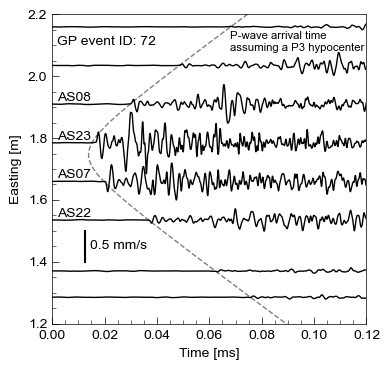

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(4.0, 3.8))

tvec = st_event_obs[0].times()*1e3
pretrigger = st_event_obs[0].stats.pretrigger
maxdist = 800

for i, tr_obs in enumerate(st_event_obs):
    
    stnm = tr_obs.stats.station
    sensorloc = channel_loc[stnm]
    sensorloc_x = sensorloc[0]/1e3
    
    print(stnm)

    if stnm=="OL08":
        lc = "k" #lc_dict[datacase]
    else:
        lc = "k"
            
    if (tr_obs.stats.dist > maxdist) : #skip sensors for visuallization
        continue;
        
    # Apply high-pass filter
    # using sos to minimize the numerical error of filter
    sos = signal.butter(butterworth_order, [freqmin, freqmax], 'bandpass', fs=tr_obs.stats.sampling_rate, output='sos')
    # sos = signal.butter(butterworth_order, [freqmin], 'highpass', fs=tr_obs.stats.sampling_rate, output='sos')
    tr_obs_filtered = tr_obs.copy().taper(0.05)
    # tr_obs_filtered.data = signal.sosfilt(sos, tr_obs_filtered.data)
    # Apply the band-pass filter
    b, a = signal.butter(butterworth_order, (freqmin, freqmax), 'bandpass', fs=tr_obs.stats.sampling_rate, output='ba')
    # tr_obs_filtered.data = signal.filtfilt(b, a, tr_obs_filtered.data, method='gust') # using two-way filter Gustafsson’s method
    tr_obs_filtered.data = signal.lfilter(b, a, tr_obs_filtered.data) # apply one-way filter to avoid acausal signal


    ampnorm = 5.0e-3 #1.8e-3
    
    ax.plot(tvec-pretrigger, tr_obs_filtered.data/ampnorm + sensorloc_x, "-", lw=1, c=lc, zorder=2 )

    # if stnm=="OL08":
    if stnm in ["OL07", "OL08", "OL22", "OL23"]:
        ax.text(0.002, sensorloc_x+0.01, f"AS{stnm[2:]}", c=lc)
        
# plot p wave arrival time with given gouge patch location
ax.plot(p_arriv_t, p_arriv_x, "--", lw=1, c="gray", zorder = 1 )
    
# ax.plot(0.01, gouge_loc, "ko")
ax.text(0.068, 2.083, "P-wave arrival time\nassuming a P3 hypocenter", fontsize=8.2)
# ax.text(0.001, 2.075, "P wave arrival time of\nthe gouge patch at G3", fontsize=9)

# annotate the scale of velocity
scale_x = 0.0125
scale_y = 1.45 #33
scale_amplitude = 0.5e-3 #[mm/s]
ax.plot([scale_x, scale_x], np.array([-scale_amplitude/2, +scale_amplitude/2])/ampnorm+scale_y, "k-");
ax.text(scale_x+0.002, scale_y, f"{scale_amplitude*1e3:.1f} mm/s", va="center")

# decoration of figure
ax.set_xlim([0.0, 0.12])
ax.set_ylim([1.2, 2.2])
# ax.set_ylim([1.0, 2.4])

ax.set_xlabel("Time [ms]")
ax.set_ylabel("Easting [m]")

# plot title for the reference
ax.text(2e-3, 2.1, f"GP event ID: {int(tr_obs_filtered.stats.dataindex.split('__')[-1])}")

ax.tick_params(axis='x', which='major', pad=5)
fig.tight_layout()

plt.savefig(figdir + "/Fig2_waveform_{}.png".format(datacase), dpi=70)
plt.savefig(figdir + "/Fig2_waveform_{}.eps".format(datacase))

In [32]:
channel_loc

{'OL01': [190.0, 50.0, 70.0],
 'OL02': [410.0, 50.0, 70.0],
 'OL03': [640.0, 50.0, 70.0],
 'OL04': [910.0, 50.0, 70.0],
 'OL05': [1160.0, 50.0, 70.0],
 'OL06': [1370.0, 50.0, 70.0],
 'OL07': [1660.0, 50.0, 70.0],
 'OL08': [1910.0, 50.0, 70.0],
 'OL09': [2160.0, 50.0, 70.0],
 'OL10': [2410.0, 50.0, 70.0],
 'OL11': [2650.0, 50.0, 70.0],
 'OL12': [2910.0, 50.0, 70.0],
 'OL13': [3160.0, 50.0, 70.0],
 'OL14': [3410.0, 50.0, 70.0],
 'OL15': [3660.0, 50.0, 70.0],
 'OL16': [3910.0, 50.0, 70.0],
 'OL17': [285.0, -50.0, 70.0],
 'OL18': [535.0, -50.0, 70.0],
 'OL19': [785.0, -50.0, 70.0],
 'OL20': [1035.0, -50.0, 70.0],
 'OL21': [1285.0, -50.0, 70.0],
 'OL22': [1535.0, -50.0, 70.0],
 'OL23': [1785.0, -50.0, 70.0],
 'OL24': [2035.0, -50.0, 70.0],
 'OL25': [2285.0, -50.0, 70.0],
 'OL26': [2535.0, -50.0, 70.0],
 'OL27': [2785.0, -50.0, 70.0],
 'OL28': [3035.0, -50.0, 70.0],
 'OL29': [3285.0, -50.0, 70.0],
 'OL30': [3535.0, -50.0, 70.0],
 'OL31': [3785.0, -50.0, 70.0],
 'OL32': [4035.0, -50.0, 70.0]}

In [33]:
tvec

array([0.000e+00, 1.000e-04, 2.000e-04, ..., 3.098e-01, 3.099e-01,
       3.100e-01])

In [34]:
# Start time
st_event_obs[0].stats.origintime

130.73454900000002